In [1]:
%load_ext autoreload
%autoreload 2

In [247]:
%run imports.py

In [3]:
def get_mrs_fitness(x, mrs, optim_fn, n_samples=None):
    for _ in range(x.ndim):
        mrs = mrs[..., None]
    shape = list(x.shape)
    if n_samples is not None:
        shape = [n_samples] + shape
        mrs = mrs[..., None]
    xmut = x+torch.randn(shape).to(x)*mrs
    fit_diff = optim_fn(xmut) - optim_fn(x)
    return x, xmut, fit_diff

def get_optimal_mr_extreme(x, mrs, optim_fn, n_samples=None):
    x, xmut, fit_diff = get_mrs_fitness(x, mrs, optim_fn, n_samples)
    return mrs[fit_diff.min(dim=-1).values.argmin(dim=0)]

def get_optimal_mr_look_ahead(x, mrs, optim_fn, n_gen=10, n_samples=1):
    if x.ndim==2:
        x = x[None]
    f = []
    for xi in x:
        for mr in mrs:
            for i in range(n_samples):
                pops, fits = optim.run_evolution_base(xi, optim_fn, n_gen, mr=mr)
                f.append(fits.min())
    f = torch.stack(f).reshape(len(x), len(mrs), n_samples)
    return mrs[f.mean(dim=-1).argmin(dim=-1)]

In [349]:
def run_evolution_look_ahead(pop, optim_fn, n_gen, look_ahead, mrs=None, tqdm=None):
    if mrs is None:
        mrs = torch.logspace(-3, 3, 15)
    
    data = []
    loop = range(n_gen)
    if tqdm is not None:
        loop = tqdm(loop)
    for gen_idx in loop:
        mr = get_optimal_mr_look_ahead(pop, mrs, ackley, n_gen=look_ahead)
        pops, fits = optim.run_evolution_base(pop, ackley, 2, mr=mr)
        pop = pops[-1]
        fit = fits[-1]
        data.append((pop, fit, mr))
        
    pops = torch.stack([i[0] for i in data])
    fits = torch.stack([i[1] for i in data])
    mutpops = torch.stack([i[2] for i in data])
    return pops, fits, mutpops


100%|██████████| 20/20 [00:00<00:00, 1163.69it/s]


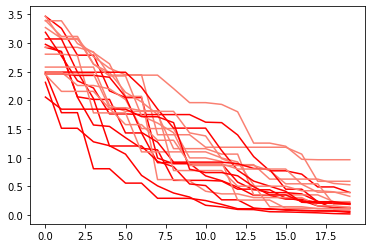

In [350]:
n_gen = 20
f = []
for i in range(10):
    pop = torch.randn(51, 5)
    pops, fits, mutpops = run_evolution_look_ahead(pop, ackley, n_gen, 5, tqdm=tqdm)
    f.append(fits)
    plt.plot(fits.min(dim=-1).values, c='r')
    pops, fits, mutpops, mr_fits = optim.run_evolution_mutpops_full(pop, ackley, n_gen, tqdm=tqdm)
    f.append(fits)
    plt.plot(fits.min(dim=-1).values, c='salmon')

In [351]:
f = torch.stack(f).reshape(10, 2, 20, 51)

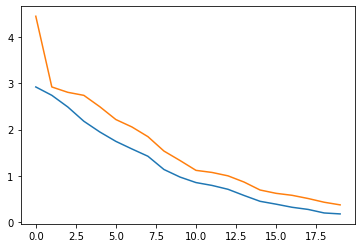

In [352]:
plt.plot(f.mean(dim=0)[0].min(dim=-1).values)
plt.plot(f.mean(dim=0)[1].min(dim=-1).values)

In [179]:
pop = torch.randn(51, 3)
pops, fits = optim.run_evolution_base(pop, ackley, 40, mr=1e-2)

In [180]:
pops.shape, fits.shape

(torch.Size([40, 51, 3]), torch.Size([40, 51]))

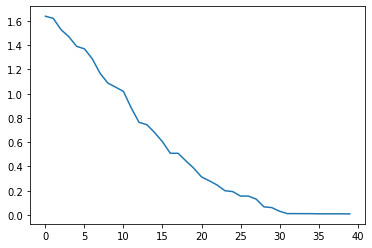

In [181]:
plt.plot(fits.min(dim=-1).values);

100%|██████████| 40/40 [00:03<00:00, 12.91it/s]


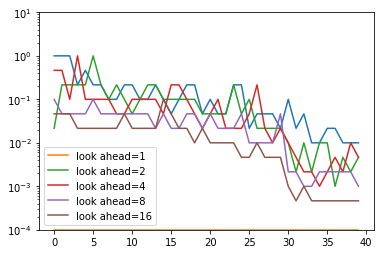

In [183]:
mrs = torch.logspace(-4, 1, 16)
mr = get_optimal_mr_extreme(pops, mrs, ackley)
plt.plot(mr)
for look_ahead in [1, 2, 4, 8, 16]:
    mr = get_optimal_mr_look_ahead(pops, mrs, ackley, n_gen=look_ahead)
    plt.plot(mr, label=f'look ahead={look_ahead}')
plt.yscale('log')
plt.ylim(mrs.min(), mrs.max())
plt.legend()

100%|██████████| 10/10 [00:23<00:00,  2.30s/it]


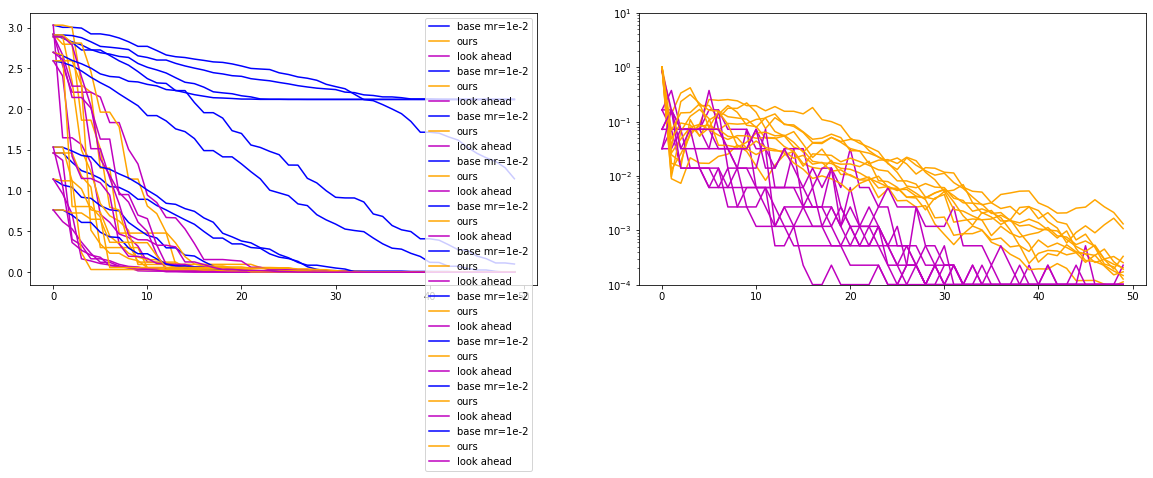

In [288]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
for i in tqdm(range(10)):
    pop = torch.randn(31, 3)
    pops, fits = optim.run_evolution_base(pop, ackley, 50, mr=1e-2)
    axs[0].plot(fits.min(dim=-1).values, c='b', label='base mr=1e-2')
    pops, fits, mr_pop, _ = optim.run_evolution_mutpops_full(pop, ackley, 50, mr=None)
    axs[0].plot(fits.min(dim=-1).values, c='orange', label='ours')
    p = pop
    f = []
    ms = []
    for gen_idx in range(50):
        mr = torch.tensor(1e-2)
        mrs = torch.logspace(-4, 1, 15)
        mr = get_optimal_mr_look_ahead(p, mrs, ackley, 10)
        ms.append(mr)
        p, fits = optim.run_evolution_base(p, ackley, 2, mr=mr)
        p = p[-1]
        f.append(fits[0])
    f = torch.stack(f)
    axs[0].plot(f.min(dim=-1).values, c='m', label='look ahead')
    axs[0].legend()
    axs[1].plot(torch.stack(ms), c='m')
    axs[1].plot(mr_pop[:, :, 0].log().mean(dim=-1).exp(), c='orange')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-4, 1e1)
plt.show()

torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])
torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])
torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])
torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])
torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])


(0.001, 1000.0)

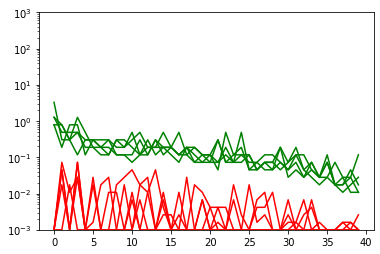

In [132]:
mrs = torch.logspace(-3, 3, 30)
for _ in range(5):
    x, xmut, fit_diff = get_mrs_fitness(pops, mrs, ackley)
    print(x.shape, xmut.shape, fit_diff.shape)
    plt.plot(mrs[fit_diff.min(dim=-1).values.argmin(dim=0)], c='g')
    plt.plot(mrs[fit_diff.mean(dim=-1).argmin(dim=0)], c='r')
plt.yscale('log')
plt.ylim(1e-3, 1e3)

In [129]:
mrs = torch.logspace(-3, 3, 10)
gens = torch.arange(0, len(pops), 2)
ms = []
for x in tqdm(pops[gens]):
    f = get_optimal_mrs(x, mrs, ackley, 10, 1)
    ms.append(mrs[f.mean(dim=-1).argmin()])

100%|██████████| 20/20 [00:00<00:00, 31.50it/s]


(0.001, 1000.0)

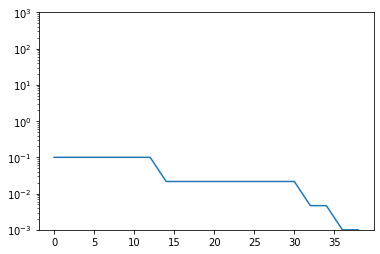

In [130]:
plt.plot(gens, ms)
plt.yscale('log')
plt.ylim(1e-3, 1e3)

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


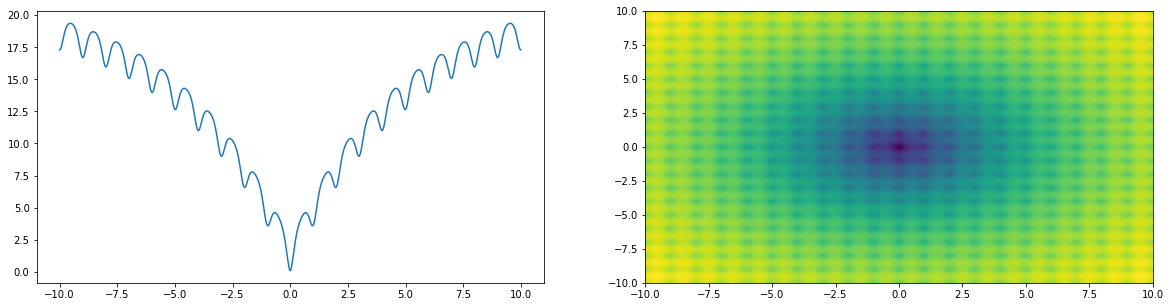

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


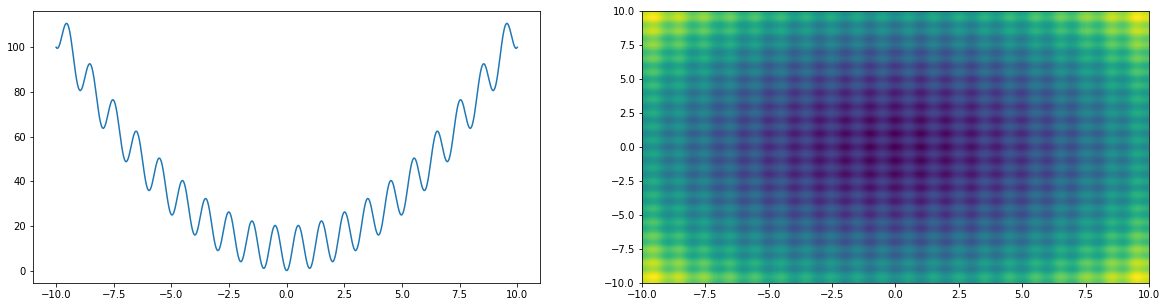

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


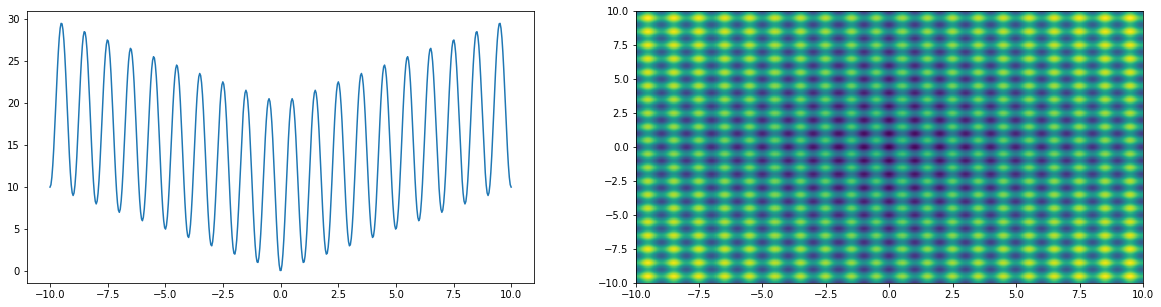

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


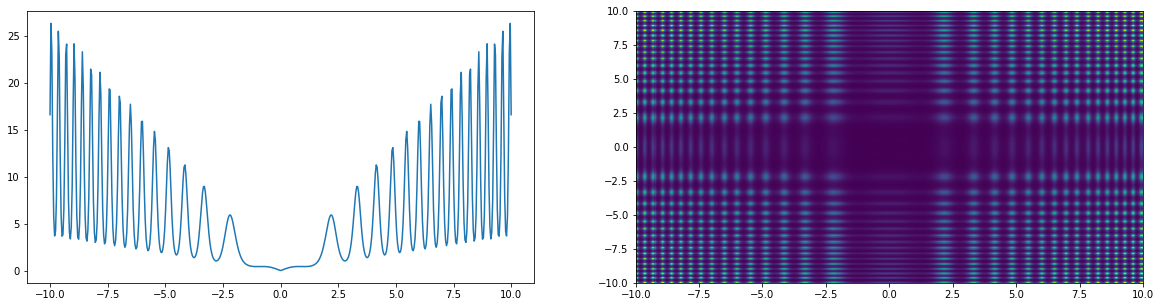

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


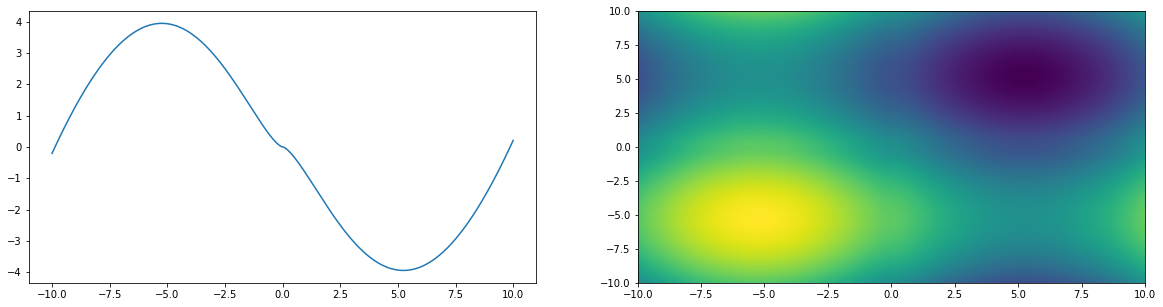

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


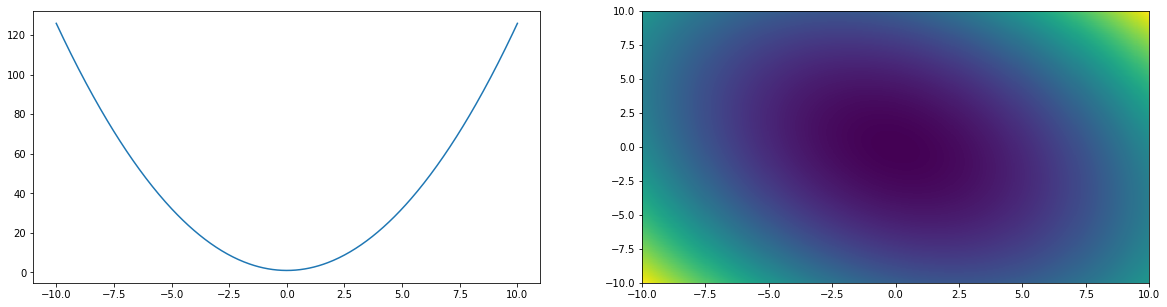

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


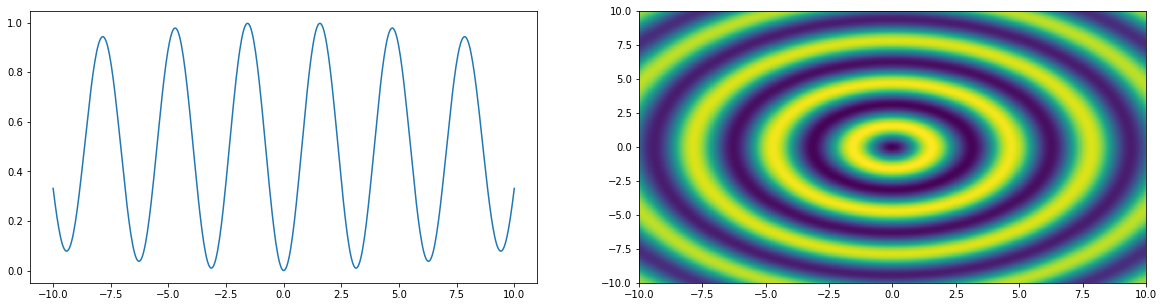

In [292]:
x = torch.linspace(-10, 10, 500)
y = torch.linspace(-10, 10, 500)
# x = torch.linspace(-500, 500, 1000)
# y = torch.linspace(-500, 500, 1000)
xm, ym = torch.meshgrid(x, y)

for optim_fn in [ackley, rastrigin, myrastrigin, xin_she_yang, schwefel, zakharov, schaffer]:
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(x, optim_fn(x[:, None]))
    plt.subplot(122)
    z = torch.stack([xm, ym], dim=-1)
    z = optim_fn(z)
    plt.pcolormesh(x, y, z)
    plt.show()
    

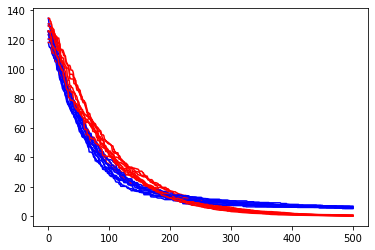

In [255]:
for i in range(10):
    do_seed(i)
    pop = torch.randn(101, 100)*0.1
    optim_fn = rastrigin
#     ofmr, _ = calc_ofmr(pop, optim_fn, n_gen, ofmr_mrs, 3, tqdm=tqdm)
#     print(ofmr)
    pops, fits_ofmr = run_evolution_base(pop, optim_fn, n_gen, mr=.0072, k=k)
    plt.plot(fits_ofmr.min(dim=-1).values, c='b')
    pops, fits_ours, mrs_ours, _ = run_evolution_ours(pop, optim_fn, n_gen, n_mutpop=10, mr_mut=2., k=k)
    plt.plot(fits_ours.min(dim=-1).values, c='r')

In [296]:
def run_experiment(n_pop, n_dim, init_pop_var, optim_fn, n_gen, k=.5, 
                   log_mr_low=-2.5, log_mr_high=0, n_mrs=8,
                   la_look_ahead=100, la_every_k=100, la_n_sims=3,
                   n_seeds=5):
    method_names = ['1CMR', 'OFMR', 'NSMR', 'GSMR', '15MR', 'LAMR']
    data = {i:{'fits': [], 'mrs': []} for i in method_names}
    for i in tqdm(range(n_seeds)):
        do_seed(i)
        pop = torch.randn(n_pop, n_dim)*init_pop_var

        ofmr_mrs = torch.logspace(log_mr_low, log_mr_high, n_mrs)
        la_mrs = torch.logspace(log_mr_low, log_mr_high, n_mrs)
        
        mr_1c = torch.tensor(1./pop.shape[-1])
        pops, fits_1c = run_evolution_base(pop, optim_fn, n_gen, mr=mr_1c, k=k)
        data['1CMR']['fits'].append(fits_1c); data['1CMR']['mrs'].append(mr_1c.repeat(n_gen+1, 1))

        ofmr, _ = calc_ofmr(pop, optim_fn, n_gen, ofmr_mrs, 3)
        pops, fits_ofmr = run_evolution_base(pop, optim_fn, n_gen, mr=ofmr, k=k)
        data['OFMR']['fits'].append(fits_ofmr); data['OFMR']['mrs'].append(ofmr.repeat(n_gen+1, 1))

        pops, fits_la, mrs_la = run_evolution_look_ahead(pop, optim_fn, n_gen, 
                                                         la_mrs, la_look_ahead, la_every_k, la_n_sims,
                                                         k=k)
        data['LAMR']['fits'].append(fits_la); data['LAMR']['mrs'].append(mrs_la[..., None])

        pops, fits_ours, mrs_ours, _ = run_evolution_ours(pop, optim_fn, n_gen, n_mutpop=10, mr_mut=2., k=k)
        data['GSMR']['fits'].append(fits_ours); data['GSMR']['mrs'].append(mrs_ours[..., 0])

        pops, fits_ns, mrs_ns = run_evolution_ns(pop, optim_fn, n_gen, mr_mut=2.0, k=k)
        data['NSMR']['fits'].append(fits_ns); data['NSMR']['mrs'].append(mrs_ns[..., 0])

        pops, fits_15, mrs_15 = run_evolution_one_fifth(pop, optim_fn, n_gen, 1e-2, mr_mut=1.05, k=k)
        data['15MR']['fits'].append(fits_15); data['15MR']['mrs'].append(mrs_15[..., None])

    for i in method_names:
        data[i]['fits'] = torch.stack(data[i]['fits']).min(dim=-1).values
        data[i]['mrs'] = torch.stack(data[i]['mrs']).log().mean(dim=-1).exp()
    return data

In [297]:
from matplotlib import colors

In [298]:
import copy
kwargs = {'n_pop': 101, 'n_dim': 100, 'init_pop_var': 6., 
          'optim_fn': ackley, 'n_gen': 500, 'k':.5,  
          'log_mr_low':-2.5, 'log_mr_high':0, 'n_mrs':8, 
          'la_look_ahead':100, 'la_every_k':100, 'la_n_sims':3, 
          'n_seeds':10}
datas = []

datas.append((kwargs, run_experiment(**kwargs)))

kwargs = {'n_pop': 101, 'n_dim': 100, 'init_pop_var': 2., 
          'optim_fn': rastrigin, 'n_gen': 500, 'k':.5,  
          'log_mr_low':-2.5, 'log_mr_high':0, 'n_mrs':8, 
          'la_look_ahead':100, 'la_every_k':100, 'la_n_sims':3, 
          'n_seeds':10}
datas.append((kwargs, run_experiment(**kwargs)))

kwargs = {'n_pop': 101, 'n_dim': 100, 'init_pop_var': 1., 
          'optim_fn': sphere, 'n_gen': 200, 'k':.5,  
          'log_mr_low':-2.5, 'log_mr_high':0, 'n_mrs':8, 
          'la_look_ahead':30, 'la_every_k':30, 'la_n_sims':3, 
          'n_seeds':10}
datas.append((kwargs, run_experiment(**kwargs)))

kwargs = {'n_pop': 101, 'n_dim': 100, 'init_pop_var': 1., 
          'optim_fn': lin_fn, 'n_gen': 50, 'k':.5,  
          'log_mr_low':-2, 'log_mr_high':7, 'n_mrs':8, 
          'la_look_ahead':10, 'la_every_k':10, 'la_n_sims':3, 
          'n_seeds':10}
datas.append((kwargs, run_experiment(**kwargs)))

# for optim_fn in [ackley, rastrigin]:
# for optim_fn in [ackley, rastrigin, sphere, lin_fn]:
#     kwargs['optim_fn'] = optim_fn
#     data = run_experiment(**kwargs)
#     datas.append((copy.deepcopy(kwargs), data))

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


In [299]:
method_name2color = {'1CMR': 'cornflowerblue', 'OFMR': 'blue', 'NSMR': 'green', 'GSMR':'red', '15MR':'magenta', 'LAMR': 'yellow'}

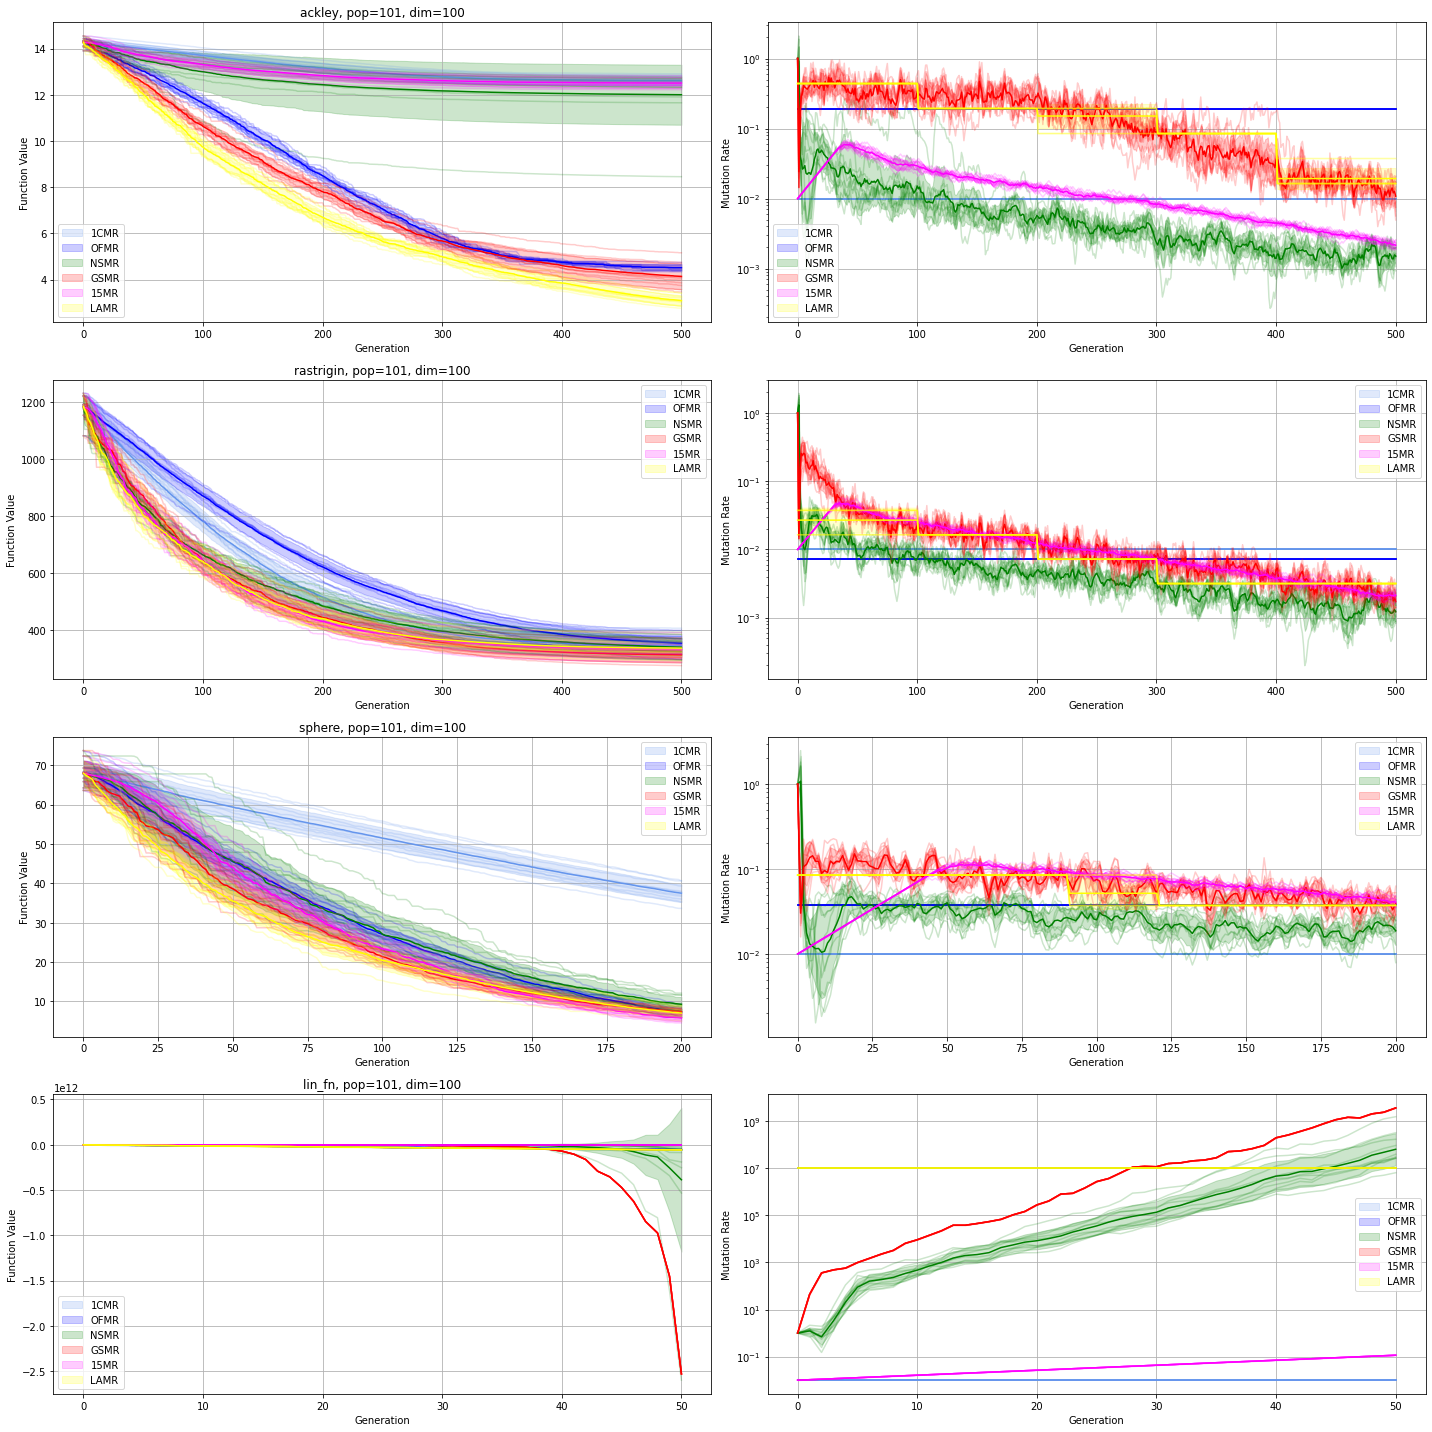

In [300]:
def plot_datas(datas):
    fig, axs = plt.subplots(len(datas), 2, figsize=(20,5*len(datas)))
    for i, (kwargs, data) in enumerate(datas):
        plt.sca(axs[i][0])
        optim_fn, n_pop, n_dim = kwargs['optim_fn'], kwargs['n_pop'], kwargs['n_dim']
        plt.title(f'{optim_fn.__name__}, pop={n_pop}, dim={n_dim}')
        plt.xlabel('Generation');plt.ylabel('Function Value')
        for method_name in method_names:
            plot_graph(data[method_name]['fits'], method_name, method_name2color[method_name])
        plt.grid()

        plt.sca(axs[i][1])
        plt.xlabel('Generation');plt.ylabel('Mutation Rate')
        for method_name in method_names:
            plot_graph(data[method_name]['mrs'], method_name, method_name2color[method_name], logscale=True)
        plt.grid()
    plt.tight_layout()

plot_datas(datas)

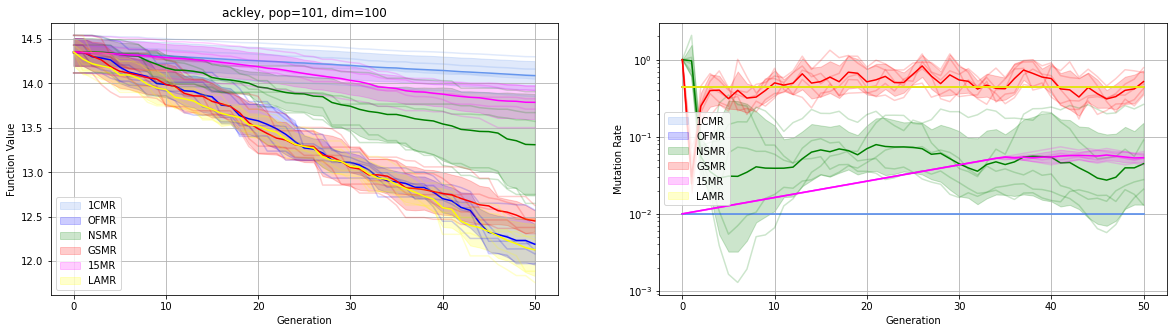

In [171]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
plt.sca(axs[0])
plt.title(f'{optim_fn.__name__}, pop={n_pop}, dim={n_dim}')
plt.xlabel('Generation');plt.ylabel('Function Value')
method_colors = ['cornflowerblue', 'blue', 'green', 'red', 'magenta', 'yellow']
for method_name, method_color in zip(method_names, method_colors):
    plot_graph(data[method_name]['fits'].min(dim=-1).values, method_name, method_color)
plt.grid()

plt.sca(axs[1])
plt.xlabel('Generation');plt.ylabel('Mutation Rate')
for method_name, method_color in zip(method_names, method_colors):
    plot_graph(data[method_name]['mrs'].log().mean(dim=-1).exp(), method_name, method_color, logscale=True)
plt.grid()

In [1497]:
for dim in np.logspace(0, 3, 7):
    dim = int(dim)
    ofmr = []
    for i in tqdm(range(5)):
        ofmr.append(calc_ofmr(torch.randn(101, dim), ackley, 100, ofmr_mrs, 3)[0].item())
    print(dim, ofmr)


  0%|          | 0/5 [00:00<?, ?it/s]

1 [tensor(0.0032), tensor(0.0032), tensor(0.0032), tensor(0.0032), tensor(0.0032)]


  0%|          | 0/5 [00:00<?, ?it/s]

3 [tensor(0.0072), tensor(0.0072), tensor(0.0072), tensor(0.0072), tensor(0.0072)]


  0%|          | 0/5 [00:00<?, ?it/s]

10 [tensor(0.0848), tensor(0.0164), tensor(0.0164), tensor(0.0164), tensor(0.0164)]


  0%|          | 0/5 [00:00<?, ?it/s]

31 [tensor(0.0848), tensor(0.0848), tensor(0.0848), tensor(0.0848), tensor(0.0848)]


  0%|          | 0/5 [00:00<?, ?it/s]

100 [tensor(0.0373), tensor(0.0848), tensor(0.0848), tensor(0.0848), tensor(0.0848)]


  0%|          | 0/5 [00:00<?, ?it/s]

316 [tensor(0.0373), tensor(0.0373), tensor(0.0373), tensor(0.0373), tensor(0.0373)]


100%|██████████| 5/5 [00:25<00:00,  5.09s/it]

1000 [tensor(0.0164), tensor(0.0373), tensor(0.0373), tensor(0.0373), tensor(0.0373)]


In [721]:
def run_evolution_dir(pop, optim_fn, n_gen, n_mutpop=10, mr=None, mr_mut=2., tqdm=lambda x: x):
    if mr is None:
        mutpop = torch.logspace(-3, 3, n_mutpop, device=pop.device)[:, None]
        mutpop_mean = torch.zeros(n_mutpop, pop.shape[-1], device=pop.device)
        mutpop = mutpop.repeat(1, pop.shape[-1])
    else:
        mutpop = torch.linspace(mr, mr, n_mutpop, device=pop.device)[:, None]
        
    data = []
    mrpop2mr = np.arange(len(pop)-1)//int(len(pop)/len(mutpop))
    fit = optim_fn(pop)
    for i in tqdm(range(n_gen)):
        bpop = pop
        bfit = fit
        
        idxs_elite, idxs_rest, idxs_cat = calc_npop_idxs(fit)
#         pop = calc_npop_gaussian(pop, mutpop[mrpop2mr], idxs_elite, idxs_rest, idxs_cat)
        pop = calc_npop_gaussian_mean_std(pop, mutpop_mean[mrpop2mr], mutpop[mrpop2mr],
                                          idxs_elite, idxs_rest, idxs_cat)
        fit = optim_fn(pop)
        fit_mrs = (fit[1:]-bfit[idxs_rest]).reshape(len(mutpop), -1)
        data.append((bpop, bfit, mutpop, fit_mrs))
        fit_mrs = fit_mrs.min(dim=-1).values
        ie, ir, ic = calc_npop_idxs(fit_mrs)
        mutpop = calc_npop_gaussian(mutpop, 1e-2, ie, ir, ic)
        mutpop_mean = calc_npop_log_uniform(mutpop_mean, mr_mut, ie, ir, ic)
        
    # pops, fits, mrs, fitmrs
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]



(-5.0, 25.0)

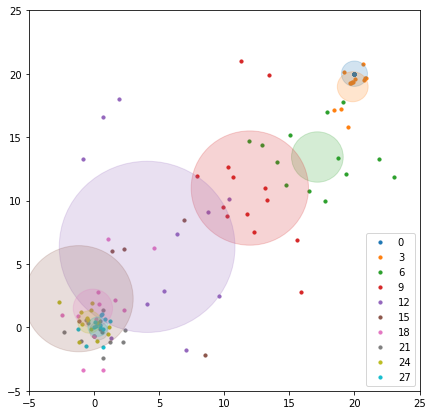

In [773]:
from matplotlib import colors
plt.figure(figsize=(7,7))
for i in range(0, len(pops), 3):
    p = pops[i]
    c = plt.gca()._get_lines.get_next_color()
    c = colors.hex2color(c)
    plt.scatter(*p.T, s=10, color=c, label=f'{i}')
    s = mrs[:, :, 0].log().mean(dim=-1).exp()[i]
    circle1 = plt.Circle(p.mean(dim=0), s, color=list(c)+[.2])
    plt.gca().add_patch(circle1)
    
plt.legend()
plt.xlim(-5, 25)
plt.ylim(-5, 25)

tensor(0.4833)


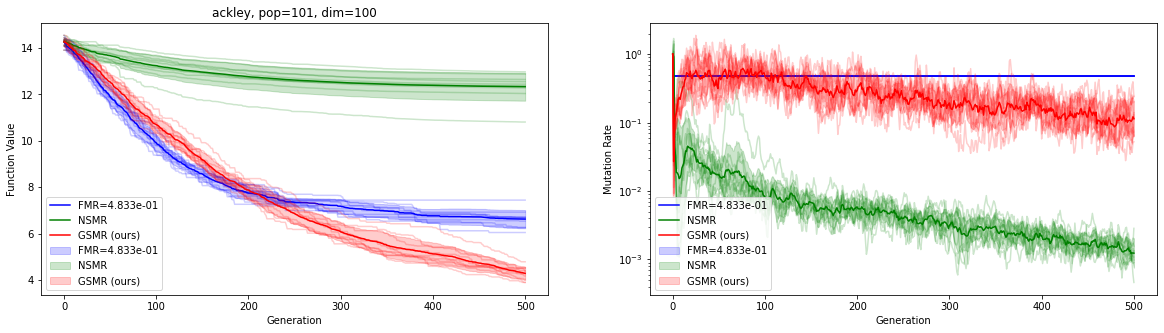

tensor(0.4833)


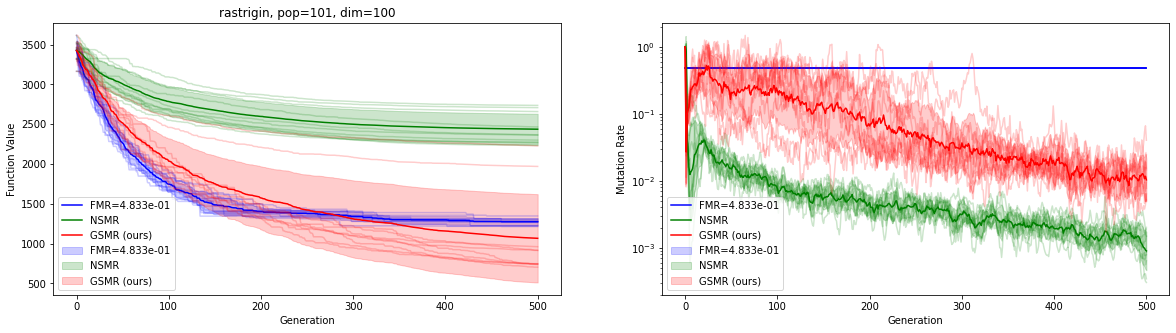

tensor(0.4833)


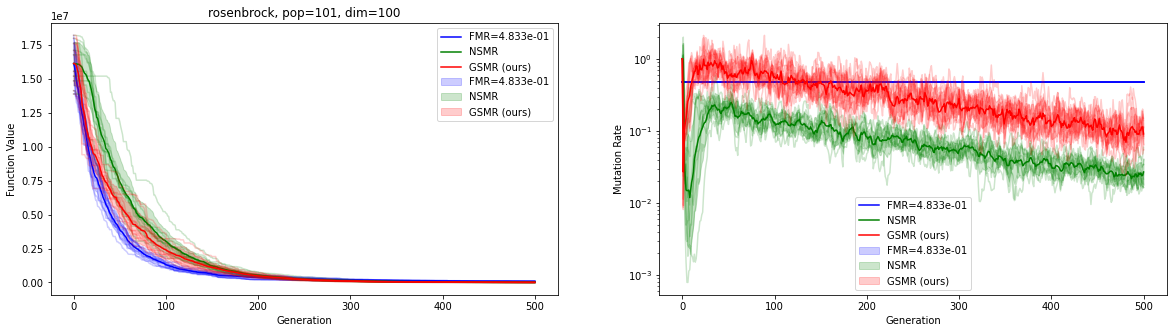

tensor(0.4833)


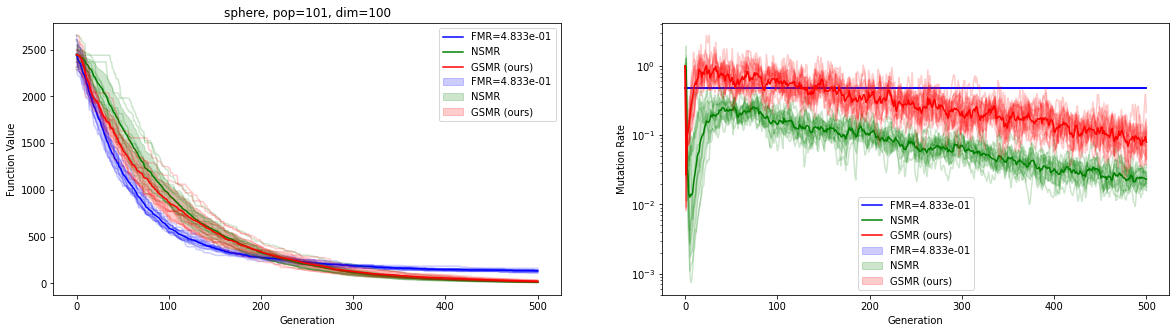

In [1140]:
for optim_fn in [ackley, rastrigin, rosenbrock, sphere]:
# for optim_fn in [ackley]:
    names = ['FMR', 'NSMR', 'GSMR (ours)']
    cs = ['blue', 'green', 'red']
    n_pop = 101
    n_dim = 100
    n_seed = 10
    n_gen = 500
    mr = 1e-2
    
    const = 6.
    
    pop = torch.randn(n_pop, n_dim)*const
    mrs = torch.logspace(-3, 0, 20)
#     mrs = [1e-2]
    ofmr, _ = get_optimal_fmr(pop, optim_fn, 100, mrs, 3)
    print(ofmr)
    names[0] = names[0]+f'={ofmr:.03e}'
    
    f = []
    mrs_ns = []
    mrs_ours = []
    for i in range(n_seed):
        do_seed(i)
        pop = torch.randn(n_pop, n_dim)*const
        pops, fits = run_evolution_base(pop, optim_fn, n_gen, mr=ofmr)
        f.append(fits)
        pops, fits, mrs = run_evolution_ns(pop, optim_fn, n_gen, mr=None)
        f.append(fits);mrs_ns.append(mrs)
        pops, fits, mrs, fits_mr = run_evolution_ours(pop, optim_fn, n_gen, 4, mr=None)
        f.append(fits);mrs_ours.append(mrs)
    f = torch.stack(f)
    fmin = f.reshape(n_seed, 3, *f.shape[1:]).min(dim=-1).values
    mrs_ns = torch.stack(mrs_ns)
    mrs_ns = mrs_ns[..., 0].log().mean(dim=-1).exp()
    mrs_ours = torch.stack(mrs_ours)
    mrs_ours = mrs_ours[..., 0].log().mean(dim=-1).exp()
    
    fig, axs = plt.subplots(1, 2, figsize=(20,5))
    plt.sca(axs[0])
    for i in range(3):
        plot_graph(fmin[:, i], names[i], cs[i])
    plt.title(f'{optim_fn.__name__}, pop={n_pop}, dim={n_dim}')
    plt.xlabel('Generation');plt.ylabel('Function Value')
    plt.sca(axs[1])
    plt.xlabel('Generation');plt.ylabel('Mutation Rate')
    plot_graph(torch.full_like(mrs_ns, ofmr), names[0], cs[0], logscale=True)
    plot_graph(mrs_ns, names[1], cs[1], logscale=True)
    plot_graph(mrs_ours, names[2], cs[2], logscale=True)
    
    plt.show()

